<a href="https://colab.research.google.com/github/CNG85-HW/CNG_Voodeo/blob/main/CNG_Voodeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model loaded successfully!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!
Upload your reference images and video.


Saving 20241223_132831.jpg to 20241223_132831 (3).jpg
Saving 20241223_132836.mp4 to 20241223_132836 (3).mp4
Object '20241223_132831 (3)' detected in frame 41 with confidence 0.91


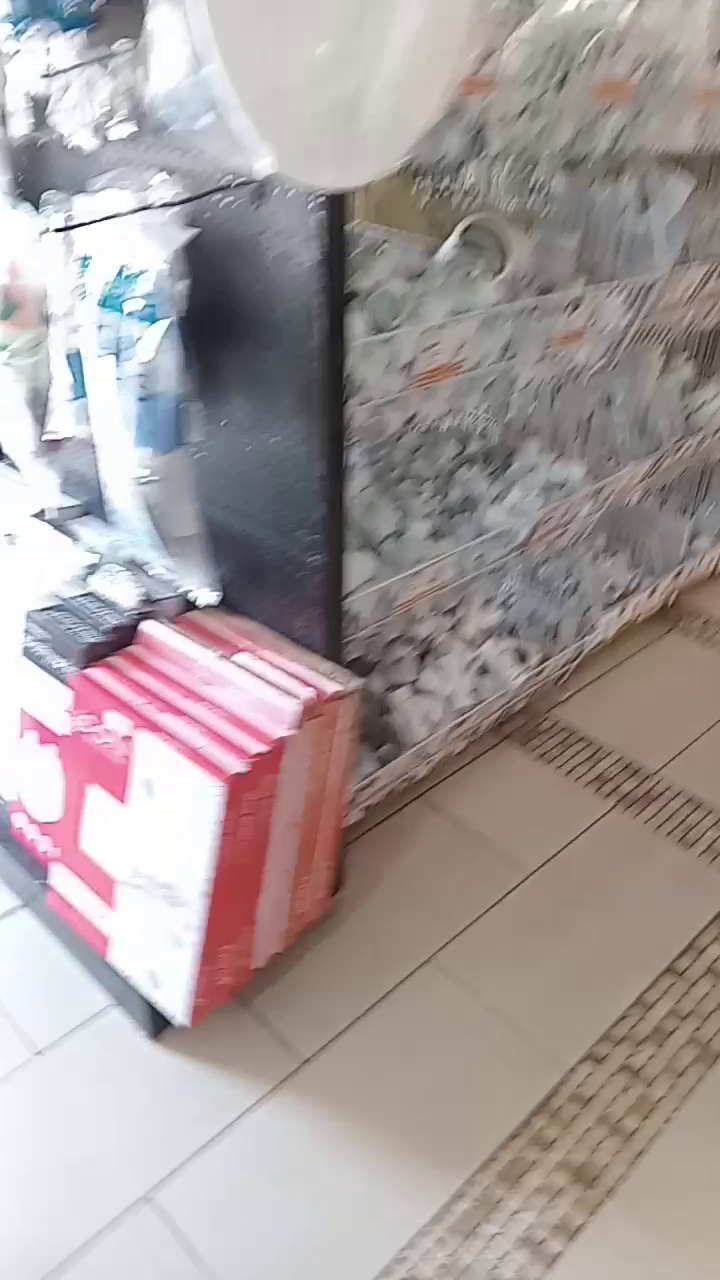

Object '20241223_132831 (3)' detected in frame 43 with confidence 0.95


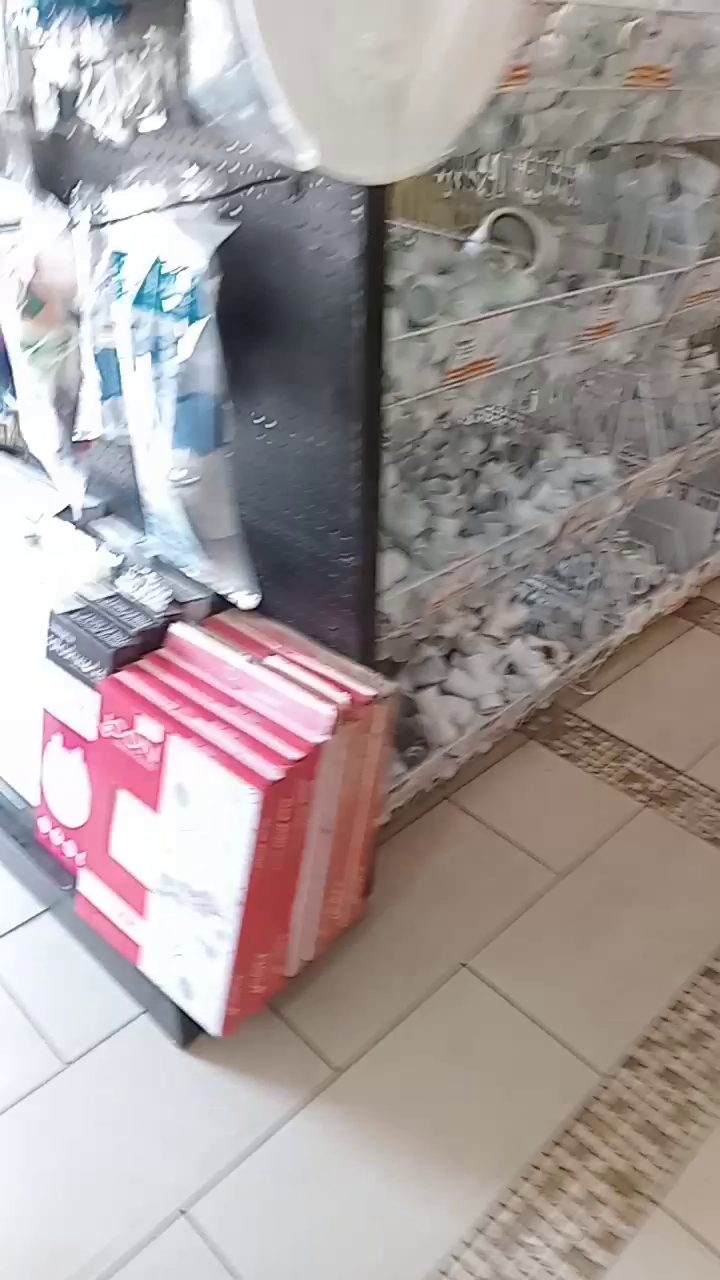

Object '20241223_132831 (3)' detected in frame 44 with confidence 0.99


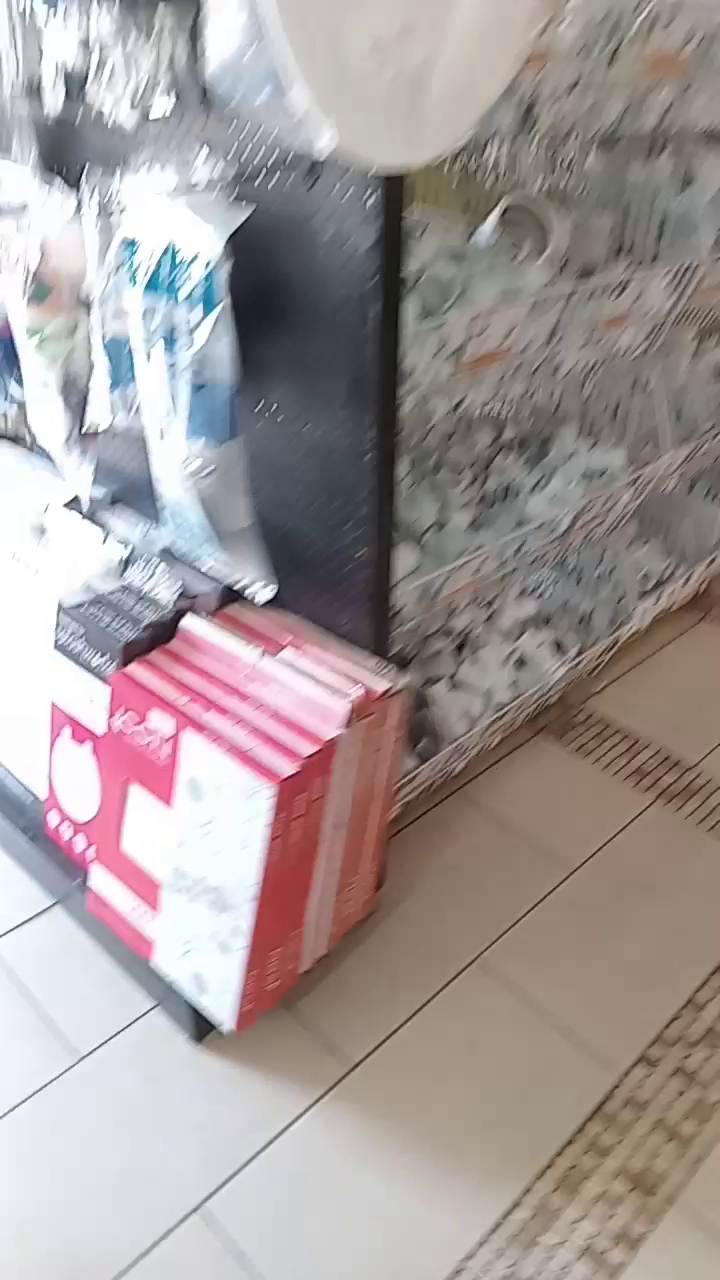

Object '20241223_132831 (3)' detected in frame 45 with confidence 0.90


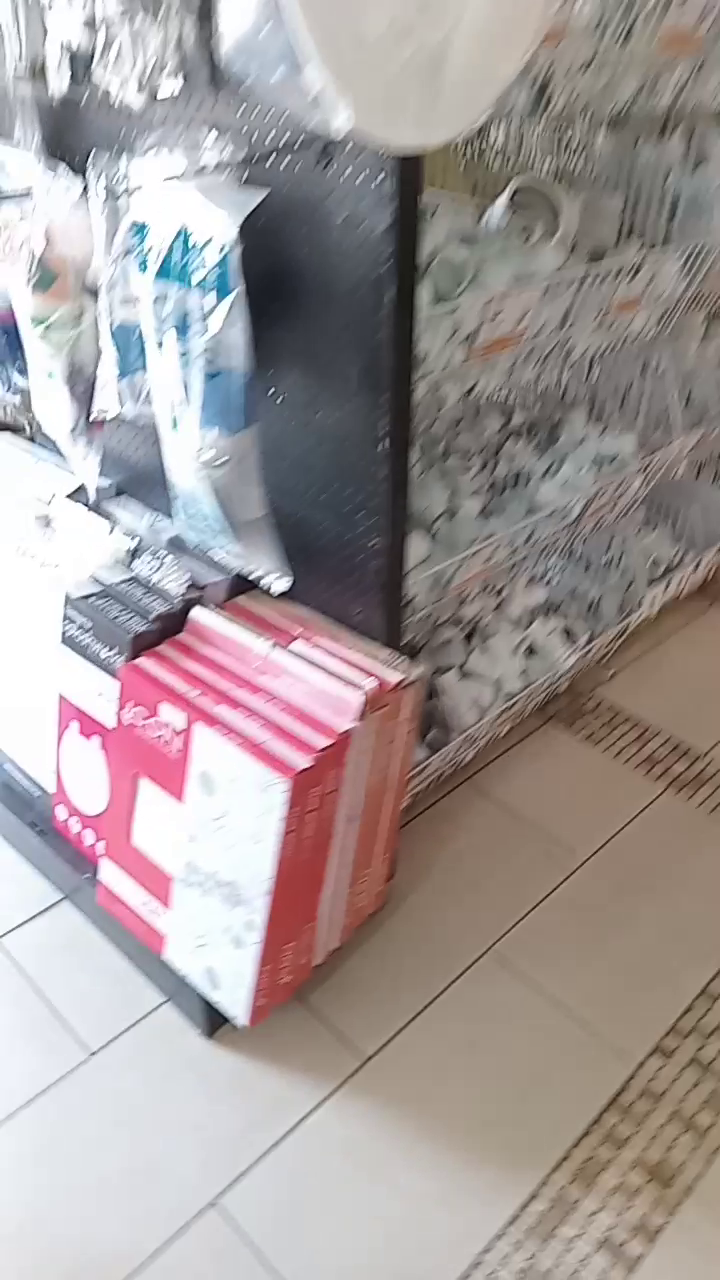

Object '20241223_132831 (3)' detected in frame 46 with confidence 0.91


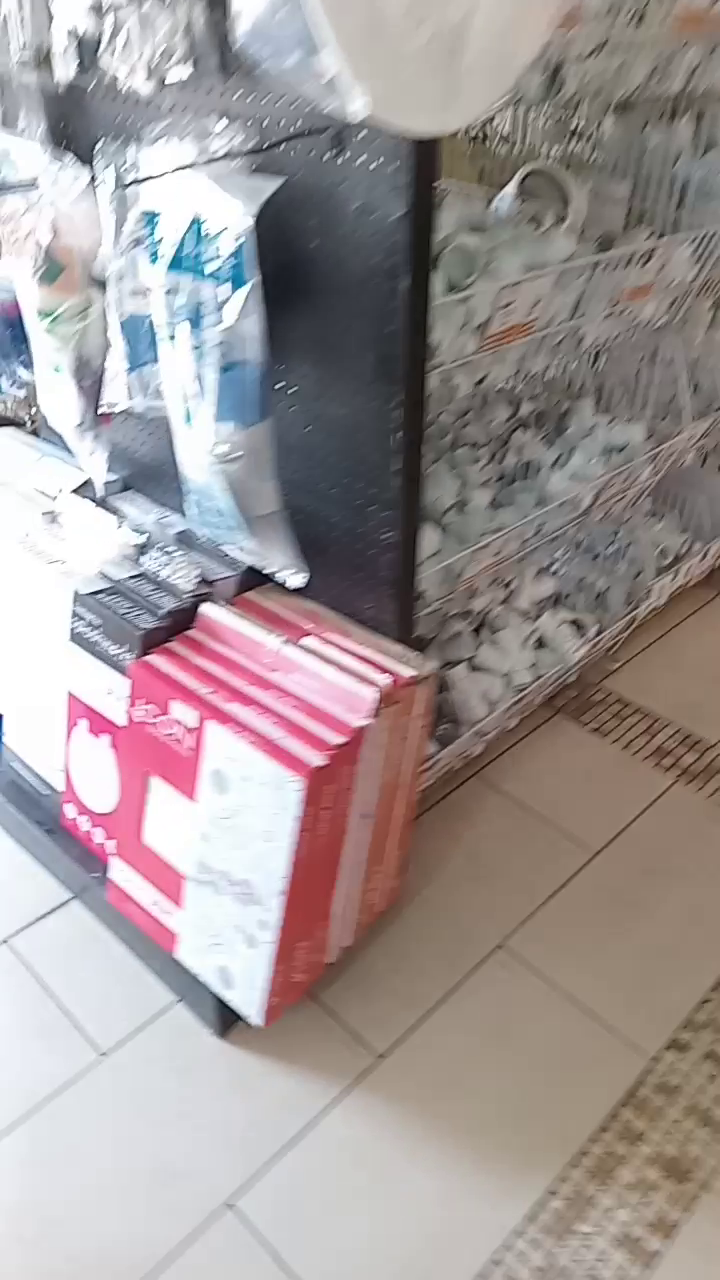

Object '20241223_132831 (3)' detected in frame 47 with confidence 0.85


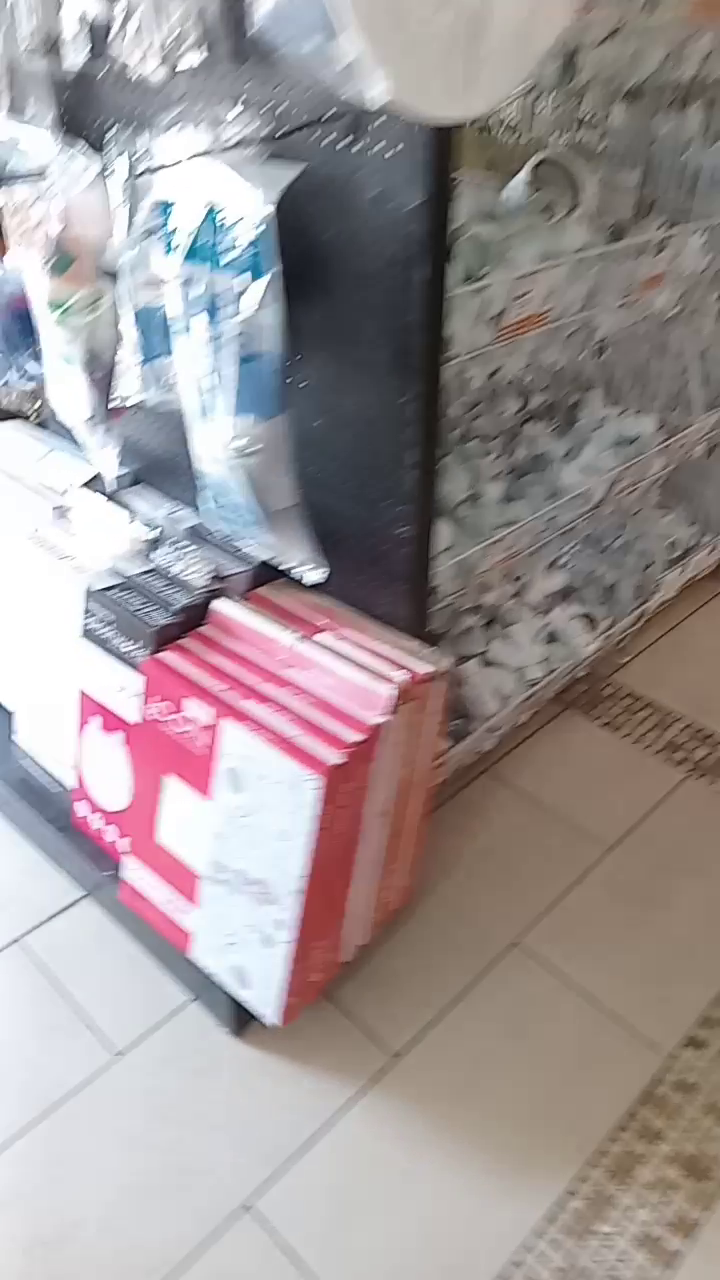

Object '20241223_132831 (3)' detected in frame 89 with confidence 0.89


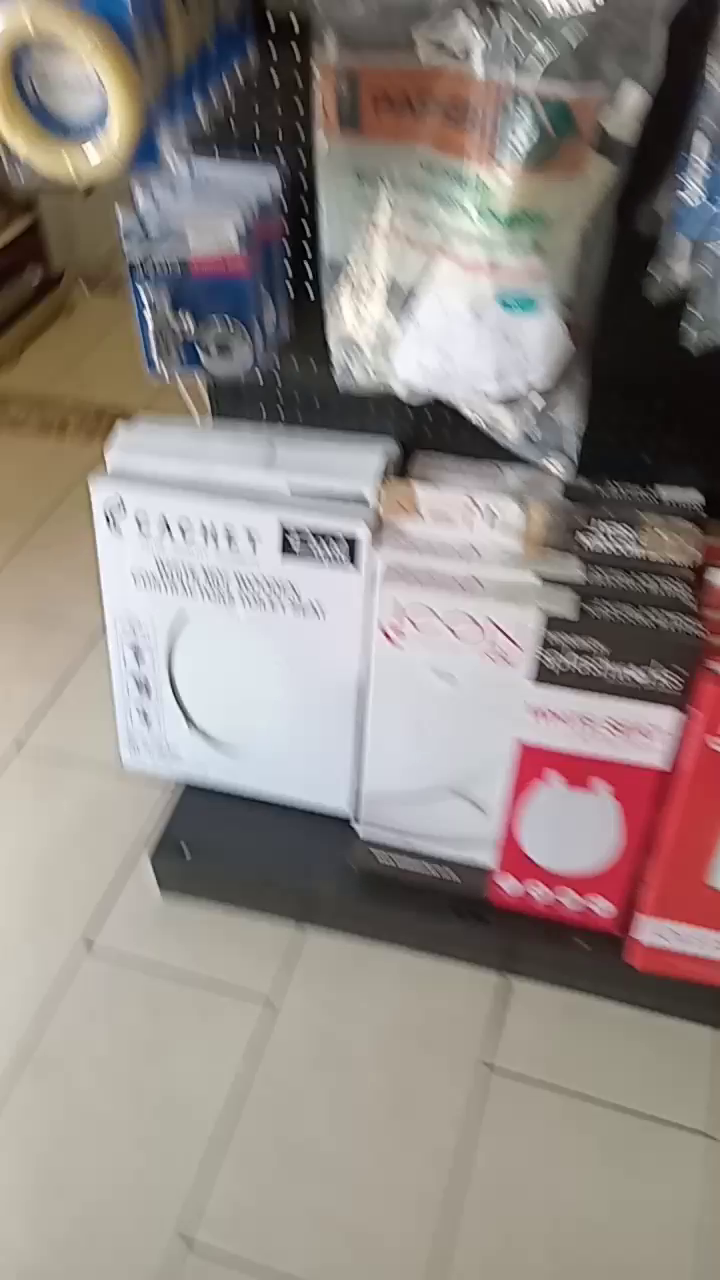

Object '20241223_132831 (3)' detected in frame 99 with confidence 0.88


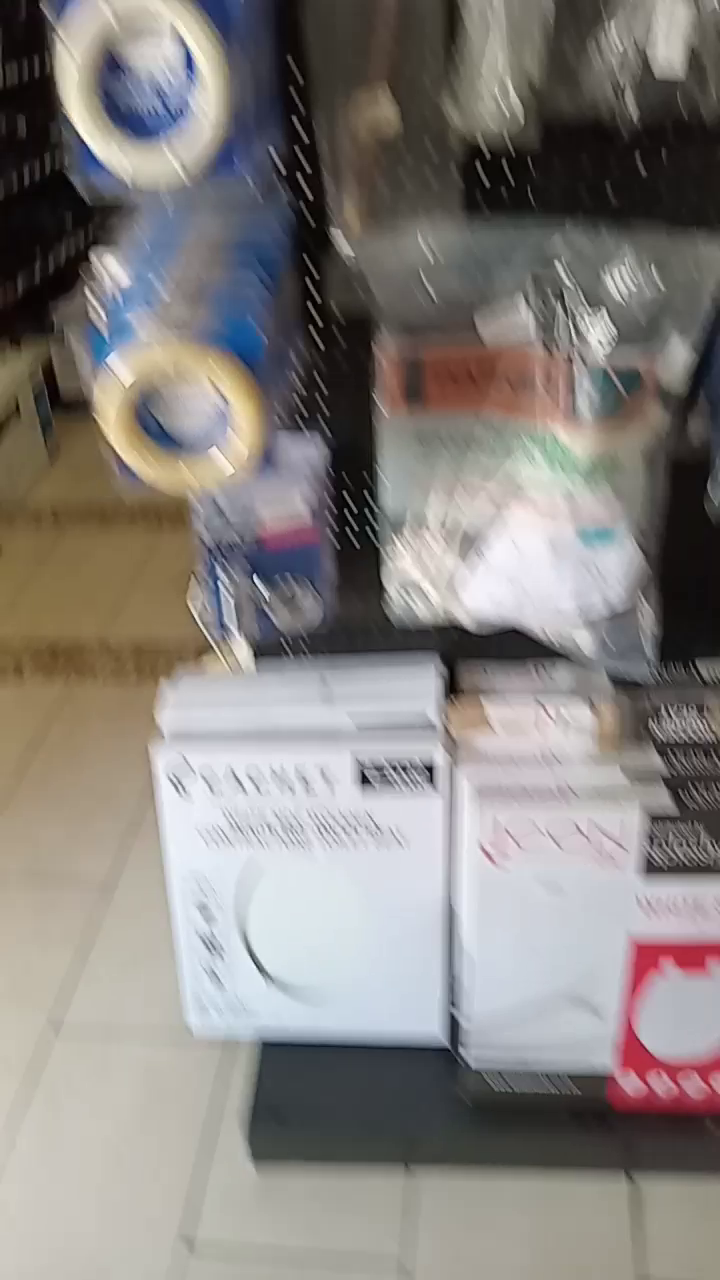

Object '20241223_132831 (3)' detected in frame 100 with confidence 0.87


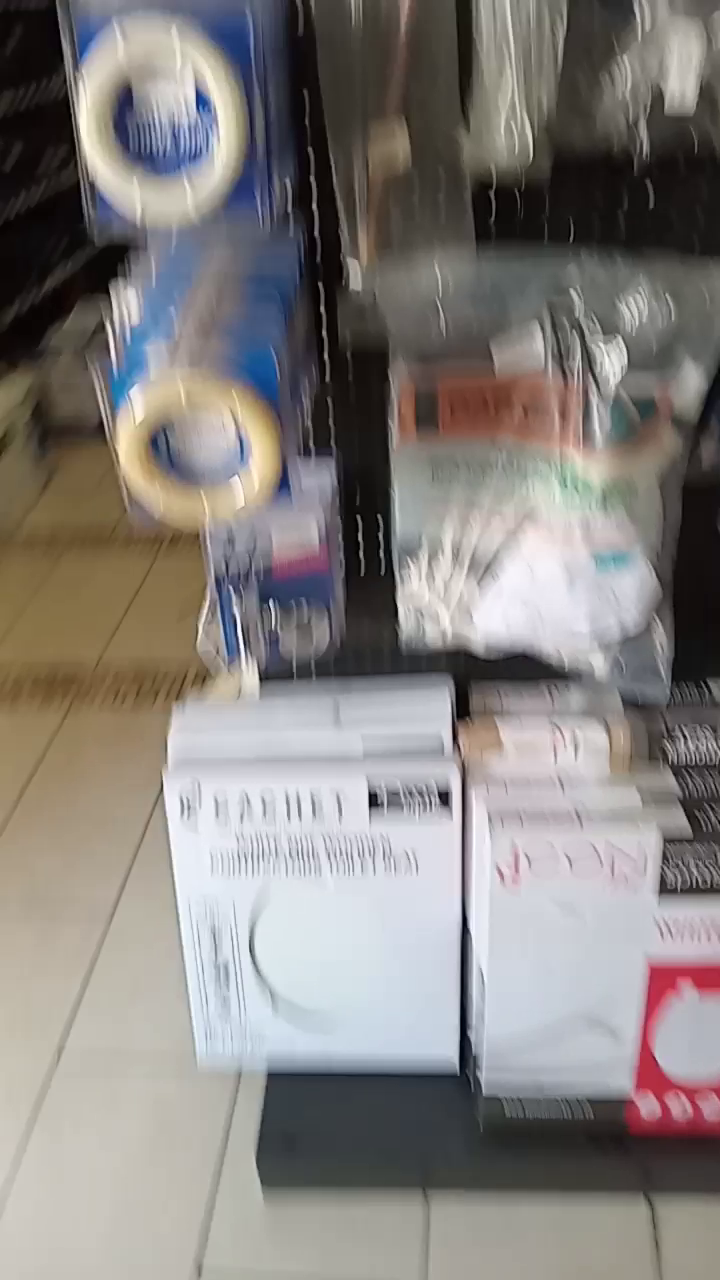

KeyboardInterrupt: 

In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from google.colab.patches import cv2_imshow # Import the cv2_imshow function

try:
    from google.colab import drive, files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Function to upload files in Colab or get paths in other environments
def get_files():
    """Gets reference image and video paths, using Colab's file upload if available,
    otherwise prompting the user for local paths."""

    reference_images = {}
    video_path = None

    if IN_COLAB:
        print("Upload your reference images and video.")
        uploaded = files.upload()
        for file_name in uploaded.keys():
            if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                object_name = file_name.rsplit('.', 1)[0]  # Use filename (without extension) as the label
                reference_images[object_name] = file_name
            elif file_name.lower().endswith(('.mp4', '.avi')):
                video_path = file_name
    else:
        print("Provide paths to your reference image and video.")
        reference_image_path, video_path = get_file_paths()  # Call helper function for local paths
        # Simulate reference_images dictionary
        reference_images = {os.path.basename(reference_image_path).split('.')[0]: reference_image_path}

    if not reference_images or not video_path:
        raise ValueError("Please provide at least one reference image and one video file.")
    return reference_images, video_path

# Helper function for getting local file paths (used if not in Colab)
def get_file_paths():
    """Prompts the user to enter paths to the reference image and video."""
    reference_image_path = input("Enter the path to the reference image: ")
    video_path = input("Enter the path to the video: ")

    if not os.path.exists(reference_image_path) or not os.path.exists(video_path):
        raise FileNotFoundError("One or both of the provided file paths do not exist.")

    return reference_image_path, video_path


# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the model path in Google Drive
model_dir = "/content/drive/My Drive/models/ssd_mobilenet_v2_coco_2018_03_29"
model_path = os.path.join(model_dir, "saved_model")

# Step 3: Check if the model directory exists; if not, prompt user to upload it
if not os.path.exists(model_path):
    print(f"Model directory not found at {model_path}. Please upload the model to the folder:\n{model_dir}")
    raise FileNotFoundError("Model not found. Upload it to Google Drive first.")

# Step 4: Load the TensorFlow model
try:
    model = tf.saved_model.load(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", str(e))
    raise

# Function to upload multiple images and one video
def upload_files():
       reference_images = {}
       video_path = None

       # Local execution
       reference_image_path = input("Enter the path to the reference image: ")
       video_path = input("Enter the path to the video: ")

       # Assuming image filename is the object label
       object_name = os.path.basename(reference_image_path).split('.')[0]
       reference_images[object_name] = reference_image_path

       if not reference_images or not video_path:
           raise ValueError("Please provide at least one reference image and one video file.")
       return reference_images, video_path

# Function to preprocess reference images
def preprocess_images(image_paths):
    processed_images = {}
    for label, path in image_paths.items():
        image = Image.open(path)
        image_np = np.array(image)
        input_tensor = tf.convert_to_tensor(image_np)
        processed_images[label] = input_tensor[tf.newaxis, ...]
    return processed_images

# Function to detect objects in the video
def detect_objects_in_video(video_path, reference_images):
    processed_images = preprocess_images(reference_images)

    cap = cv2.VideoCapture(video_path)
    frame_number = 0
    detection_results = {label: [] for label in processed_images.keys()}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        input_tensor = tf.convert_to_tensor(frame)
        input_tensor = input_tensor[tf.newaxis, ...]

        detections = model.signatures['serving_default'](input_tensor)
        detection_scores = detections['detection_scores'].numpy()
        detection_boxes = detections['detection_boxes'].numpy()
        detection_classes = detections['detection_classes'].numpy()

        for label, reference_tensor in processed_images.items():
            if detection_scores[0][0] > 0.85:  # Adjust confidence threshold as needed
                print(f"Object '{label}' detected in frame {frame_number} with confidence {detection_scores[0][0]:.2f}")
                detection_results[label].append(frame_number)
                cv2_imshow(frame) # Use cv2_imshow instead of cv2.imshow
                cv2.waitKey(0)  # Added waitKey to display the image
                cv2.destroyAllWindows() # Added destroyAllWindows to close the window after display

        frame_number += 1

    cap.release()

    for label, frames in detection_results.items():
        print(f"\nObject '{label}' detected in {len(frames)} frame(s): {frames}")

# Main function to run the script
def main():
    if IN_COLAB:
        drive.mount('/content/drive') # Mount Google Drive if in Colab
        model_dir = "/content/drive/My Drive/models/ssd_mobilenet_v2_coco_2018_03_29" # Update with your Colab path
    else:
        model_dir = "models/ssd_mobilenet_v2_coco_2018_03_29"  # Update with your local path

    model_path = os.path.join(model_dir, "saved_model")

    if not os.path.exists(model_path):
        print(f"Model directory not found at {model_path}. Please download and place the model in the specified folder.")
        raise FileNotFoundError("Model not found.")

    try:
        model = tf.saved_model.load(model_path)
        print("Model loaded successfully!")
    except Exception as e:
        print("Error loading model:", str(e))
        raise

    reference_images, video_path = get_files()
    detect_objects_in_video(video_path, reference_images)

if __name__ == "__main__":
    main()

    print("Upload your reference images and video.")
    reference_images, video_path = get_files()  # Use get_files for both Colab and local
    detect_objects_in_video(video_path, reference_images)

# Run the main function
if __name__ == "__main__":
    main()
